<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *AIB / SECTION 2 / SPRINT 3 / NOTE 3*

# 📝 Assignment
---
# Feature Importances

### 1) 지속적으로 포트폴리오 프로젝트를 수행하세요
- 지속적으로 데이터를 랭글링 하고 추가적인 시각화 결과를 만드세요
- 작성한 코드마다 적절한 코멘트를 추가하세요
- 모델을 학습시키고 베이스라인 모델과 비교해 보세요
- **포트폴리오 프로젝트의 베이스라인 모델이 무엇인지 한 문장으로 설명하세요.** 

In [1]:
# ! pip install category_encoders

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor

from sklearn.linear_model import RidgeCV, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, f1_score, roc_curve, classification_report, plot_confusion_matrix, roc_auc_score
from scipy.stats import randint, uniform

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# 자료 출처 : 서울 열린데이터 광장 - 서울특별시 부동산 실거래가 정보
# https://data.seoul.go.kr/dataList/OA-15548/S/1/datasetView.do

df = pd.read_csv('https://docs.google.com/uc?export=download&id=1WyeDe2Ry4ohJobcbnQJXHxFEAtcg-CC_', encoding='cp949')

# 서울 부동산 물건금액 예측해보기
# 1) 가격 예측
# 2) 고가 주택(9억 초과)과 고가 주택 아닌 것으로 분류(물건가격으로 특성 만든 후 물건금액 특성 제거를 통해 정보 누수 예방하기)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# 지번 코드를 기준으로 할 것이므로 지번코드 자릿수가 19가 아닌 것을 제거
# 제거될 데이터는 전체의 10% 미만임
df = df[df['지번코드'].map(str).apply(len) == 19]

# 층정보 -1인 경우는 실제로 반지하일 수도 있겠으나, 데이터의 수가 전체의 약 3% 수준이라 영향이 크지 않다고 판단함
# 층정보 -2, -3인 경우는 부호 표기가 반대로 된 것으로 판단함
# 따라서 음수인 층정보는 양수로 바꾸는 것으로 처리
tmp_idx = df[df['층정보'] < 0]['층정보'].index
df.loc[tmp_idx, ['층정보']] = df[df['층정보'] < 0]['층정보'].mul(-1)

# 건축년도가 nan 또는 0인 데이터가 있다
# 전체 데이터의 약 1% 이므로 제거
df = df[(df['건축년도'] != 0) & ~(df['건축년도'].isna())]
len(df[(df['건축년도'] == 0) | (df['건축년도'].isna())])

# 층정보와 건물명이 없는 데이터는 모두 단독주택이므로 층정보는 2로 대체
# (건축법 상 단독주택(단독주택/다중주택/다가구주택)은 3개 층 이하로 제한되어 있음 -> 1~3의 중간값인 2로 대체)
# 참고 : https://justdim.tistory.com/146
df['층정보'] = df['층정보'].fillna(2)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [4]:
# 불필요한 컬럼 제거

# # 대지권면적은 결측치가 대다수이므로 제거
# # 참고 : https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=ctrfindit&logNo=221272287733
# df = df.drop('대지권면적', axis=1)

# # 실제로 건물명이 가격에 영향을 줄 것이라는 심증이 있으나(브랜드 가치 등의 이유),
# # 현재로서는 처리할 방법을 모르기 때문에 건물명 컬럼은 제거
# df = df.drop('건물명', axis=1)

# # 실거래가아이디는 거래 자체의 고유 번호이므로 가격과 관련없다고 판단하여 컬럼 제거
# df = df.drop('실거래가아이디', axis=1)

# # 법정동코드는 지번코드에서 '필지구분(1)+본번(4)+부번(4)'을 제외한 것으로서, 지번코드가 법정동코드의 정보를 반영한다고 봄
# # 따라서 법정동코드 컬럼 제거. 시군구코드도 지번코드에 포함되므로 컬럼 제거.
# # 자치구명, 법정동명 또한 지번코드가 모두 반영하므로 컬럼 제거
# # 참고 : https://zelkun.tistory.com/entry/%EB%B2%95%EC%A0%95%EB%8F%99%ED%96%89%EC%A0%95%EB%8F%99-%EC%B0%A8%EC%9D%B4%EC%A0%90-%EB%B0%8F-%EA%B5%AC%EB%B3%84%ED%98%84%ED%99%A9
# df = df.drop(['법정동코드', '시군구코드', '자치구명', '법정동명'], axis=1)

# # 모든 데이터가 2020년에 신고된 거래 데이터이므로 신고년도는 불필요함. 컬럼 제거
# df = df.drop('신고년도', axis=1)

# # 업무구분 모두 '신고'이고, 업무구분코드도 모두 이에 해당하는 '4'임
# # 그 이전에 컬럼 자체도 불필요하다고 판단함. 따라서 컬럼 제거
# df = df.drop(['업무구분', '업무구분코드'], axis=1)

# # 물건번호는 경매에서 각 물건에 붙는 번호를 의미함
# # 예를 들어 한 사건에 한 개 물건이면 물건번호는 1임.
# # 일종의 고유 번호이므로 물건가격과 상관없다고 판단하여 컬럼 제거
# # 참고 : https://m.blog.naver.com/maestron1/221534254422
# df = df.drop('물건번호', axis=1)

# # 관리구분코드는 공공기관 내부적으로 사용하는 것으로 추정
# # 자세한 내용은 확인할 수 없었음
# # 명칭으로 보아 물건가격과는 관련이 없다고 보고 컬럼 제거
# df = df.drop('관리구분코드', axis=1)

# # 건물주용도코드가 건물주용도를 반영하고 있으므로 건물주용도 컬럼 제거
# df = df.drop('건물주용도', axis=1)

# 위 과정 한꺼번에 정리한 결과 가져오기
df = df[['지번코드',	'건물면적',	'층정보',	'건물주용도코드',	'물건금액',	'건축년도']]

In [5]:
# 건축년도를 그대로 사용하기보다는 몇 년이나 오래 되었는지 나타내는 컬럼이 필요하지 않을까?
df['연식'] = (2020 - df['건축년도']).astype(int)

# 건물면적을 통해 집을 소형/중형/대형으로 구분하면 어떨까?
# 기준 : 60㎡ 이하 = 소형 / 60㎡ 초과~85㎡ 이하 = 중형 / 85㎡ 초과 = 대형
# 참고 : https://www.hani.co.kr/arti/economy/property/689578.html
df['주택규모'] = df['건물면적'].apply(lambda x: 'S' if x <= 60 else 'L' if x > 85 else 'M')

# 물건금액 9억 초과를 기준으로 고가주택과 고가주택이 아닌 물건으로 분류 예측은 어떨까?
# 2020년 기준 고가주택 기준 : 9억
# 참고 : https://m.post.naver.com/viewer/postView.nhn?volumeNo=32576102&memberNo=36833282
df['고가주택여부'] = df['물건금액'].apply(lambda x: 1 if x > 900000000 else 0)

# 층정보, 건축년도는 int로 형변환하여 소수점 제거
df[['층정보', '건축년도']] = df[['층정보', '건축년도']].astype(int)

# 층정보, 건축년도, 건물주용도코드는 연속적인 수치형이 아닌 범주형으로 간주하여 컬럼 형변환
df[['층정보', '건축년도', '건물주용도코드']] = df[['층정보', '건축년도', '건물주용도코드']].astype(str)

# 컬럼명 변경하기
df.columns = ['addr_code', 'size', 'floor', 'type', 'price', 'built_year', 'years', 'size_grade', 'is_high_price']

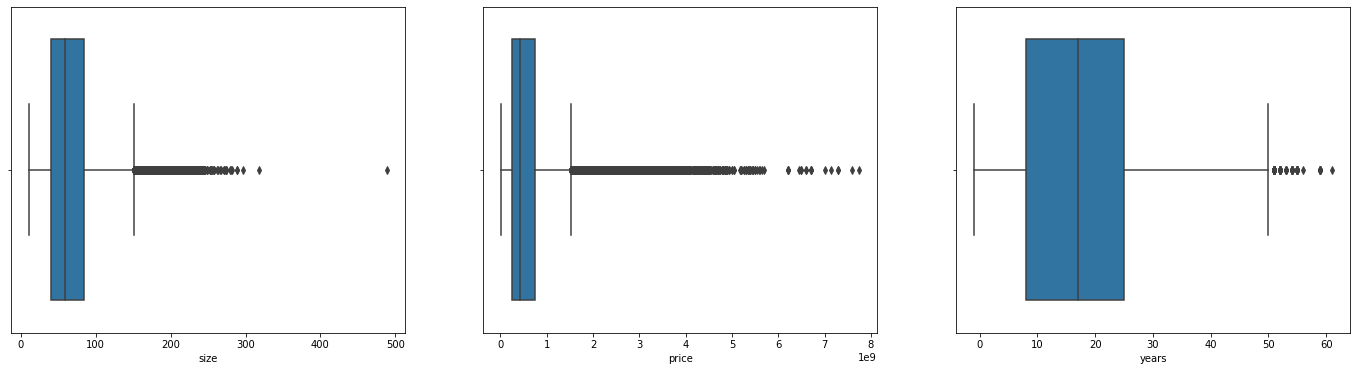

In [6]:
# 수치형 컬럼(타겟 포함)의 이상치 확인하기
col_list = ['size', 'price', 'years']

def checkOutlier(df, cols):
  fig, axes = plt.subplots(1, 3, figsize=(24, 6))
  for i, col in enumerate(col_list):
    sns.boxplot(x=col, data=df, ax=axes[i])

checkOutlier(df, col_list)

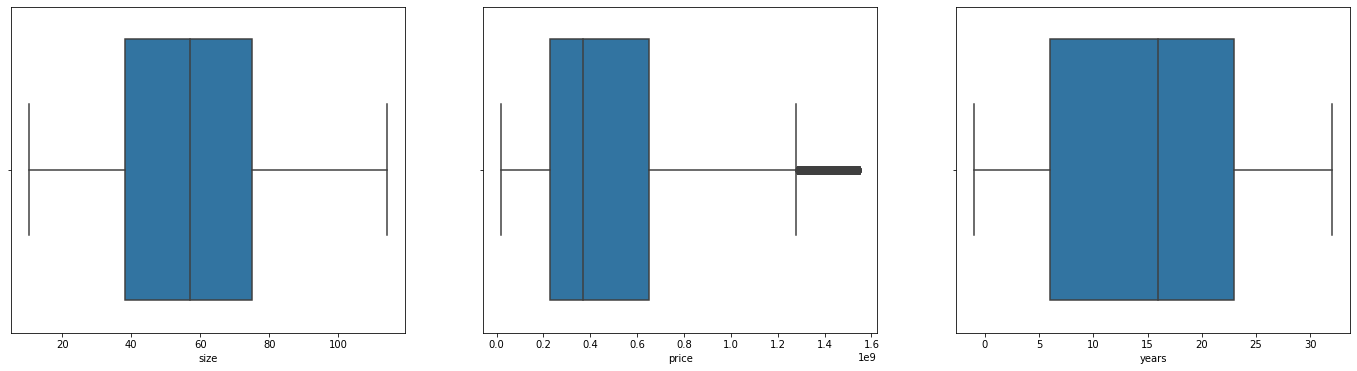

In [7]:
# 수치형 컬럼 전체적으로 이상치로 보이는 값들이 존재함
# 각각에 대하여 상위 5%를 제거
target = 'price'
df = df[df[target] < np.percentile(df[target], 95)]
df = df[df['size'] < np.percentile(df['size'], 95)]
df = df[df['years'] < np.percentile(df['years'], 95)]
checkOutlier(df, col_list)

# 인덱스 재정렬
df = df.reset_index(drop=True)

470946234.08997595


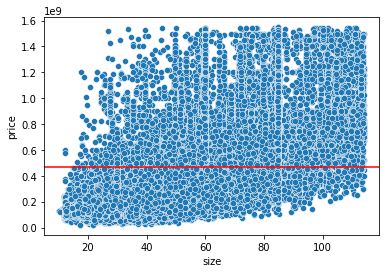

In [8]:
# 가장 상관관계가 높은 size와 타겟(price)의 관계 시각화해보기
baseline = df.price.mean() # 기준 모델 : 타겟(price)의 평균값
print(baseline)

sns.scatterplot(x='size', y='price', data=df)
plt.axhline(baseline, color='red'); # 기준 모델 시각화

# 기준 모델의 의미 : 2020년 서울 부동산 물건가격(실거래가)의 평균

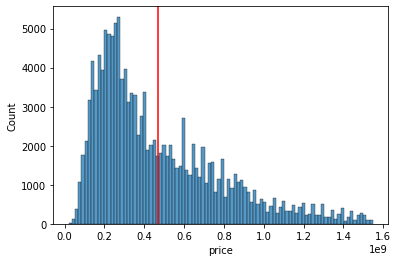

In [9]:
# 타겟(price)의 분포 확인해보기
sns.histplot(df.price, kde=False);
plt.axvline(baseline, color='red'); # 기준 모델 시각화
# price는 right-skewed이므로 로그 변환이 필요

In [10]:
# 기준 성능(회귀)
errors = baseline - df.price
baseline_mae = errors.abs().mean()
baseline_mae

254535177.4446938

0    0.895478
1    0.104522
Name: is_high_price, dtype: float64

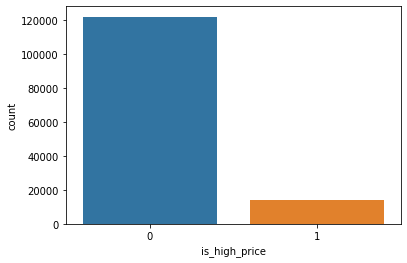

In [11]:
# 타겟(is_high_price)의 클래스 비율 확인해보기 - 기준 성능(분류)
sns.countplot(x=df.is_high_price);
df.is_high_price.value_counts(normalize=True)
# is_high_price는 클래스 비율이 불균형하므로 학습 시 class_weight 관련 설정이 필요

In [12]:
# 물건가격 예측은 회귀, 고가주택여부는 분류
# 회귀 : 릿지 회귀, 결정 트리, 랜덤 포레스트
# 분류 : 로지스틱 회귀, 결정 트리, 랜덤 포레스트

# 훈련 / 검증 / 테스트 셋으로 분리
train, test = train_test_split(df, test_size=0.30, random_state=2)
train, val = train_test_split(train, test_size=0.30, random_state=2)

train.shape, val.shape, test.shape

((66831, 9), (28643, 9), (40918, 9))

In [13]:
# 특성과 타겟 분리하기
target_cl = 'is_high_price' # 분류 문제 타겟
targets = [target, target_cl]
features = train.drop(columns=targets).columns

X_train = train[features]
y_train = train[target]
y_train_cl = train[target_cl]
X_val = val[features]
y_val = val[target]
y_val_cl = val[target_cl]
X_test = test[features]
y_test = test[target]
y_test_cl = test[target_cl]

X_train.head()

,addr_code,size,floor,type,built_year,years,size_grade
127762,1121510500107620000,84.60,1,2001,1996,24,M
44709,1120010700103040007,57.31,4,2002,1994,26,S
75903,1135010600105120000,59.26,9,2001,1991,29,S
55311,1129013600100901817,26.25,7,2002,2019,1,S
88322,1138010700100970003,84.84,4,2001,2004,16,M


In [15]:
# addr_code, type, built_year 셋은 TargetEncoder
tge_col = ['addr_code', 'type', 'built_year']
# floor, size_grade 둘은 OrdinalEncoder
ord_col = ['floor', 'size_grade']

In [62]:
# 1. 랜덤 포레스트 - 회귀
pipe_rf = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    RandomForestRegressor(n_jobs=-1, random_state=2)
)

# 과적합 줄이기 및 최적화
dists_rf = {
    'randomforestregressor__n_estimators': randint(50, 500),
    'randomforestregressor__max_depth': [5, 10, 15, 20, None],
    'randomforestregressor__min_samples_split': randint(2, 50),
    'randomforestregressor__min_samples_leaf': randint(1, 50),
    'randomforestregressor__max_features': uniform(0, 1)
}

clf_rf = RandomizedSearchCV(
    pipe_rf, 
    param_distributions=dists_rf, 
    n_iter=30, 
    cv=3, 
    scoring='r2',  
    verbose=1,
    n_jobs=-1
)

clf_rf.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 14.6min finished


In [63]:
tt_rf = TransformedTargetRegressor(regressor=clf_rf.best_estimator_,
                                func=np.log1p, inverse_func=np.expm1)

tt_rf.fit(X_train, y_train);
print('훈련 정확도: ', tt_rf.score(X_train, y_train))
print('검증 정확도: ', tt_rf.score(X_val, y_val))

y_pred_rf = tt_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Test MAE: {mae_rf:,.0f}')
print(f'R2 Score: {r2_rf:,.4f}')

훈련 정확도:  0.913290292143382
검증 정확도:  0.8694794348823224
Test MAE: 65,353,052
R2 Score: 0.8715


In [65]:
# 2. 랜덤 포레스트 - 분류
pipe_rf_cl = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    RandomForestClassifier(n_jobs=-1, random_state=2)
)

dists_rf_cl = {
    'randomforestclassifier__n_estimators': randint(50, 500),
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None],
    'randomforestclassifier__min_samples_split': randint(2, 50),
    'randomforestclassifier__min_samples_leaf': randint(1, 50),
    'randomforestclassifier__max_features': uniform(0, 1)
}

# 과적합 줄이기 및 최적화
clf_rf_cl = RandomizedSearchCV(
    pipe_rf_cl, 
    param_distributions=dists_rf_cl, 
    n_iter=30, 
    cv=3, 
    scoring='f1',  
    verbose=1,
    n_jobs=-1
)

clf_rf_cl.fit(X_train, y_train_cl);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 11.4min finished


In [66]:
print('최적 하이퍼파라미터: ', clf_rf_cl.best_params_)
print('f1: ', clf_rf_cl.best_score_)

pipe_rf_cl = clf_rf_cl.best_estimator_
print('훈련 정확도: ', pipe_rf_cl.score(X_train, y_train_cl))
print('검증 정확도: ', pipe_rf_cl.score(X_val, y_val_cl))

y_pred_rf_cl = pipe_rf_cl.predict(X_test)

f1_rf_cl = f1_score(y_test_cl, y_pred_rf_cl)
print(f'Test F1: {f1_rf_cl}')

최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__max_features': 0.5200093169920873, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 22, 'randomforestclassifier__n_estimators': 254}
f1:  0.8121307801383247
훈련 정확도:  0.9791264532926337
검증 정확도:  0.9661697447893028
Test F1: 0.8384161337924251


### 2) Xgboost를 사용해 학습하고 기존 모델과 비교해 보세요.
- 본인 포트폴리오 데이터를 Xgboost로 학습하여 기존에 만들었던 모델과 비교합니다.
- **breast cancer 데이터를 Xgboost로 학습하고 f1 score를 제출하세요.(test 데이터에서 0.95이상)**

In [17]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.impute import SimpleImputer

In [19]:
eval_set = [(X_train, y_train), 
            (X_val, y_val)]

In [69]:
# 1. 회귀
pipe_xgb = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    XGBRegressor(n_estimators=1000
              , random_state=2
              , n_jobs=-1
              , learning_rate=0.2
              , eval_set=eval_set
              , eval_metric='error' # #(wrong cases)/#(all cases)
              , early_stopping_rounds=50) # 50 rounds 동안 스코어의 개선이 없으면 멈춤
)

pipe_xgb.fit(X_train, y_train);

[11:17:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [70]:
y_pred_xgb_train = pipe_xgb.predict(X_train)
mae_xgb_train = mean_absolute_error(y_train, y_pred_xgb_train)
r2_xgb_train = r2_score(y_train, y_pred_xgb_train)
print(f'Train MAE: {mae_xgb_train:,.0f}')
print(f'R2 Score: {r2_xgb_train:,.4f}\n')

y_pred_xgb_val = pipe_xgb.predict(X_val)
mae_xgb_val = mean_absolute_error(y_val, y_pred_xgb_val)
r2_xgb_val = r2_score(y_val, y_pred_xgb_val)
print(f'Val MAE: {mae_xgb_val:,.0f}')
print(f'R2 Score: {r2_xgb_val:,.4f}\n')

y_pred_xgb = pipe_xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'Test MAE: {mae_xgb:,.0f}')
print(f'R2 Score: {r2_xgb:,.4f}')

Train MAE: 56,976,240
R2 Score: 0.9141

Val MAE: 68,776,836
R2 Score: 0.8723

Test MAE: 68,810,077
R2 Score: 0.8765


In [20]:
# 2. 분류
pipe_xgb_cl = make_pipeline(
    TargetEncoder(cols=tge_col),
    OrdinalEncoder(cols=ord_col),
    XGBClassifier(n_estimators=1000
              , random_state=2
              , n_jobs=-1
              , learning_rate=0.2
              , eval_set=eval_set
              , eval_metric='error' # #(wrong cases)/#(all cases)
              , early_stopping_rounds=50) # 50 rounds 동안 스코어의 개선이 없으면 멈춤
)

pipe_xgb_cl.fit(X_train, y_train_cl);

In [21]:
y_pred_xgb_cl_train = pipe_xgb_cl.predict(X_train)
f1_rf_cl = f1_score(y_train_cl, y_pred_xgb_cl_train)
print(f'Test F1: {f1_rf_cl}')

y_pred_xgb_cl_val = pipe_xgb_cl.predict(X_val)
f1_rf_cl = f1_score(y_val_cl, y_pred_xgb_cl_val)
print(f'Test F1: {f1_rf_cl}')

y_pred_xgb_cl = pipe_xgb_cl.predict(X_test)
f1_rf_cl = f1_score(y_test_cl, y_pred_xgb_cl)
print(f'Test F1: {f1_rf_cl}')

Test F1: 0.9014598540145985
Test F1: 0.8281730943327901
Test F1: 0.8399122807017544


In [ ]:
# ### 이곳에서 과제를 진행해 주세요 ###

# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.datasets import load_breast_cancer 

# cancer_dataset = load_breast_cancer()

# features = cancer_dataset.data
# target = cancer_dataset.target
# df = pd.DataFrame(data=features, columns=cancer_dataset.feature_names)
# df['target'] = target

# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=2)
# print(X_train.shape, X_test.shape)

# pipe = make_pipeline(
#     OrdinalEncoder(),
#     SimpleImputer(strategy='median'),
#     XGBClassifier(n_estimators=200
#                   , random_state=2
#                   , n_jobs=-1
#                   , max_depth=7
#                   , learning_rate=0.2
#                  )
# )

# pipe.fit(X_train, y_train);

# y_pred = pipe.predict(X_test)
# print(classification_report(y_pred, y_test))

### 3) Permutation importances를 계산하고 다른 중요도 결과와 비교해 보세요
- 본인 포트폴리오 데이터를 사용해 만든 모델의 Permutation importances를 계산하세요.
- **breast cancer 데이터를 사용해 만든 모델의 Permutation importances를 계산하고 가장 높은 값을 가지는 특성의 이름을 제출하세요.**
    - eli5 PermutationImportance 사용
    - scoring = 'accuracy'
    - n_iter = 5
    - random_state = 2

In [24]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe_xgb_cl.named_steps['xgbclassifier'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.
X_val_transformed = pipe_xgb_cl.named_steps['ordinalencoder'].transform(X_val)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_transformed, y_val);

In [25]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

size_grade    0.0
years         0.0
built_year    0.0
type          0.0
floor         0.0
size          0.0
addr_code     0.0
dtype: float64

In [ ]:
# pipe.named_steps

In [ ]:
# pip install eli5

In [40]:
# ### 이곳에서 과제를 진행해 주세요 ###

# import eli5
# from eli5.sklearn import PermutationImportance

# # permuter 정의
# permuter = PermutationImportance(
#     pipe.named_steps['xgbclassifier'], # model
#     scoring='accuracy', # metric
#     n_iter=5, # 다른 random seed를 사용하여 5번 반복
#     random_state=2
# )

# # permuter 계산은 preprocessing 된 X_val을 사용합니다.
# X_test_transformed = pipe.named_steps['simpleimputer'].transform(X_test)

# # 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
# permuter.fit(X_test_transformed, y_test);

In [ ]:
# feature_names = df.drop('target', axis=1).columns.tolist()
# pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

## 🔥 도전과제

### 4) Xgboost 외에 다른 부스팅 라이브러리로 모델을 학습시켜 Xgboost와 비교해 보세요.

In [ ]:
### 이곳에서 과제를 진행해 주세요 ### 